# Семинар + Домашнее Задание 4: "Методы оптимизации"

In [1]:
from functools import partial

import numpy as np
import torch
from tqdm.auto import tqdm
from torch import nn
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.pyplot import cm
from matplotlib.colors import LogNorm
from matplotlib import animation
from mpl_toolkits import mplot3d
from matplotlib.gridspec import GridSpec
from torchvision import datasets, transforms
from IPython.display import HTML
%matplotlib inline
plt.rc('animation', html='html5')

На этом семинаре мы попробуем сравнить различные методы оптимизации.

На семинаре реализуем и сравним методы:
<b>SGD, NAG, Adagrad, RMSProp</b>.



## Реализация методов

Для всех экспериментов подберите параметры так, чтобы метод сошелся к ближайшему локальному минимуму. Все методы следует запускать из одной и той же точки.

In [6]:
# https://github.com/dzlab/deepprojects/blob/master/visualization/Optimizers_in_Action.ipynb

def grid_samples(center=[0, 0], offset=5, size=100):
    range1 = np.linspace(center[0]-offset, center[0]+offset, size)
    range2 = np.linspace(center[1]-offset, center[1]+offset, size)
    return torch.from_numpy(np.stack(np.meshgrid(range1, range2))).float()


def mse(y, y_hat):
    return ((y - y_hat) ** 2).mean(axis=-1)


def msre(y, y_hat):
    return ((y - y_hat) ** 2).mean(axis=-1).sqrt()


def mae(y, y_hat):
    return ((y - y_hat).abs()).mean(axis=-1)


class LossAnimator:
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.size = len(X)

    def loss_func(self, W, loss):

        shape = W.shape
        return loss((self.X @ W.view(shape[0], -1)).T, self.y).view(shape[1:])

    def plot_loss_funcs(self, weights, fcts, titles, view=(20, 50)):
        num_fcts = len(fcts)
        fig = plt.figure(figsize=(7 * num_fcts,7))
        for i in range(num_fcts):
            loss = self.loss_func(weights, loss=fcts[i])
            ax = fig.add_subplot(1, num_fcts, i+1, projection='3d')
            ax.plot_surface(*weights, loss, cmap='viridis')
            ax.set_xlabel('w0'); ax.set_ylabel('w1'); ax.set_zlabel('Loss')
            ax.set_title(titles[i])
            ax.view_init(*view)

    def _init_animation(self, epochs, train_data):
        self.train_data = train_data
        self.epochs = epochs
        self.nmethods = len(train_data)

        weights = grid_samples(offset=5)

        max_loss = max([data['losses'].max() for data in train_data.values()])
        loss_curve = self.loss_func(weights, loss=mse)
        colors = cm.rainbow(np.linspace(0, 1, self.nmethods))


        self.fig = plt.figure(figsize=(14, 8))
        self.gs = GridSpec(2, 2, width_ratios=[1, 2.5])

        self.ax0 = self.fig.add_subplot(self.gs[0,0])
        self.lines0 = {
            name: self.ax0.plot([], [], c=c, label=name)[0]
            for name, c in zip(train_data.keys(), colors)
        }
        self.ax0.scatter(self.X[:,0], self.y, c='orange', label='Ground truth')
        self.ax0.set_ylim(self.y.min(), self.y.max())
        self.ax0.set_title('Ground truth & Model', fontsize=16)
        self.ax0.legend(loc='lower right')

        self.ax1 = self.fig.add_subplot(self.gs[:,1], projection='3d')
        self.ax1.plot_surface(*weights, loss_curve-0.5, cmap='viridis', alpha=0.8)
        self.ax1.view_init(50, 70)
        self.lines1 = {
            name: self.ax1.plot3D([], [], [], c=c, marker='o', alpha=0.9, label=name)[0]
            for name, c in zip(train_data.keys(), colors)
        }
        self.ax1.set_title('Loss', fontsize=16, pad=20)
        self.ax1.set_xlabel('w0')
        self.ax1.set_ylabel('w1')
        self.ax1.set_zlabel('Loss')
        self.ax1.legend()

        self.ax2 = self.fig.add_subplot(self.gs[1,0])
        self.lines2 = {
            name: self.ax2.plot([], [], c=c, label=name)[0]
            for name, c in zip(train_data.keys(), colors)
        }
        self.ax2.set_title('Loss', fontsize=16)
        self.ax2.set_ylabel('loss')
        self.ax2.set_ybound(0, max_loss)
        self.ax2.set_xlim(0, epochs)
        self.ax2.legend(loc='center right')

        self.fig.tight_layout()
        self.fig.subplots_adjust(top=0.85)

        plt.close()

        return self.fig

    def _animate(self, i):
        steps = np.arange(i+1)
        left = max(0, i-20)
        for name, data in self.train_data.items():
            # plot ground truth & model
            self.lines0[name].set_data(self.X[:, 0], self.X @ data['weights'][i])

            # plot loss (output of the sampling)
            self.lines1[name].set_data(data['weights'][left:i+1, 0], data['weights'][left:i+1, 1])
            self.lines1[name].set_3d_properties(data['losses'][left:i+1])

            self.lines2[name].set_data(steps, data['losses'][:i+1])

        self.fig.suptitle(f'Epoch: {i}/{self.epochs}', fontsize=22)

    def animate(self, epochs, train_data, step_skip=1):
        self._init_animation(epochs, train_data)
        anim = animation.FuncAnimation(self.fig, self._animate, frames=range(0, epochs, step_skip), interval=100 * step_skip)
        return HTML(anim.to_html5_video())

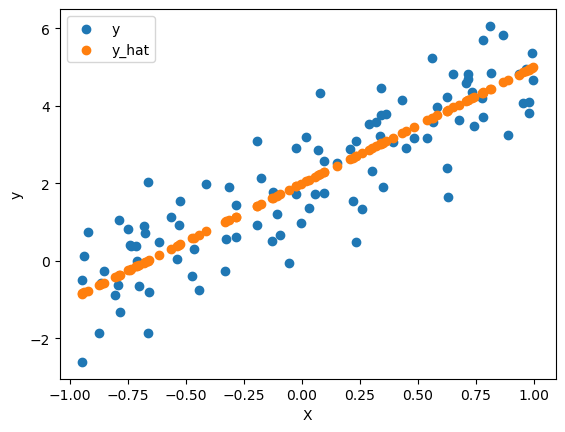

In [8]:
size = 100

def plot_data(size = 100):

    # Сгенерируем и инициализируем выборку из 100 точек
    X = torch.ones(size, 2)
    X[:, 0].uniform_(-1, 1)

    # Построим целевые значения по сгенерированным точкам следуюим образом: y = 3 * x + 2
    y_hat = 3 * X[:, 0] + 2

    # print(X)

    # Добавим шум к целевым значениям
    y = y_hat + torch.randn(size)

    loss_animator = LossAnimator(X, y)

    plt.scatter(x = X[:, 0], y = loss_animator.y, label='y')
    plt.scatter(x = X[:, 0], y = y_hat, label='y_hat')
    plt.xlabel('X')
    plt.ylabel('y')
    plt.legend()
    plt.show()

    return loss_animator

loss_animator = plot_data()

#### Другая генерация (для тренировки) -  с меньшей дисперсией шума:

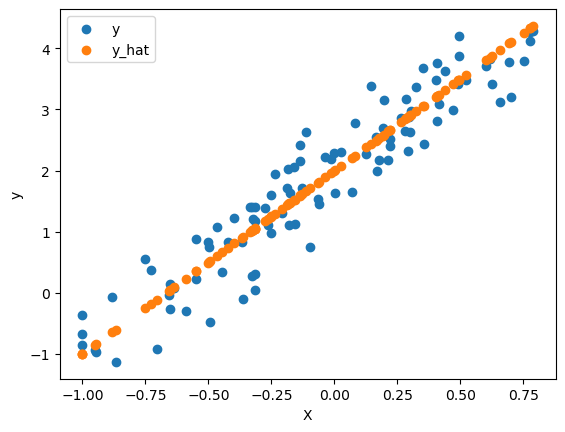

In [11]:
def plot_normal_distribution(size = 100):
    
    X = np.random.normal(0, 0.5, size)
    X = np.expand_dims(np.clip(X, -1, 1), axis = 1)
    
    fictive_ones = np.expand_dims(np.ones(shape = (100, )), axis = 1)

    X = np.concatenate([X, fictive_ones], axis = 1)

    noise = np.clip(np.random.normal(0, 0.5, size), -1, 1)

    y_hat = 3 * X[:, 0] + 2
    y = y_hat + noise

    X = torch.from_numpy(X)
    y_hat = torch.from_numpy(y_hat)
    y = torch.from_numpy(y)

    loss_animator = LossAnimator(X.float(), y)

    plt.scatter(x = X[:, 0], y = loss_animator.y, label='y')
    plt.scatter(x = X[:, 0], y = y_hat, label='y_hat')
    plt.xlabel('X')
    plt.ylabel('y')
    plt.legend()
    plt.show()

    return loss_animator

loss_animator_normal = plot_normal_distribution()

torch.Size([2, 100, 100])


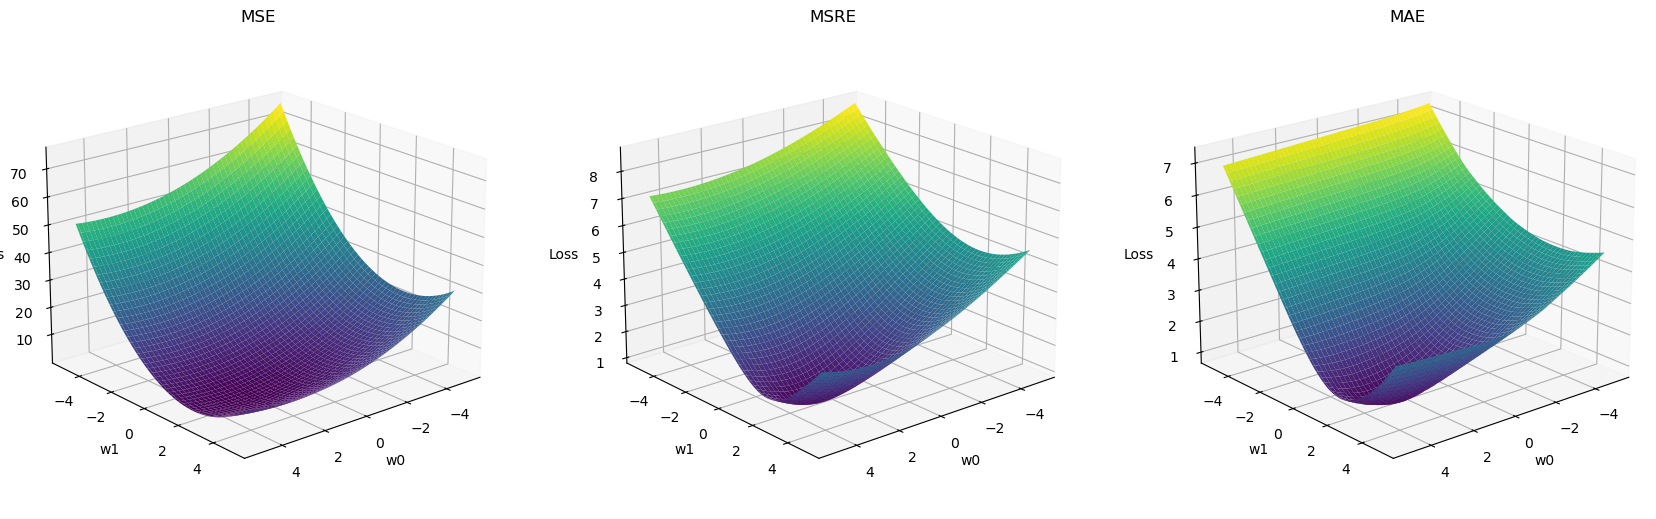

In [13]:
weights = grid_samples(center = (0, 0), offset = 5)
print(weights.size())
loss_animator.plot_loss_funcs(weights, [mse, msre, mae], ['MSE', 'MSRE', 'MAE'])

#### Некоторые записки, чтобы понять, как тут все работало

In [16]:
loss_animator.X.size()

torch.Size([100, 2])

In [18]:
loss_animator.y.size()

torch.Size([100])

In [20]:
weights.view(weights.shape[0], -1).size()

torch.Size([2, 10000])

In [22]:
(loss_animator.X @ weights.view(weights.shape[0], -1)).T.size()

torch.Size([10000, 100])

In [24]:
mse((loss_animator.X @ weights.view(weights.shape[0], -1)).T, loss_animator.y)

tensor([76.1092, 75.4932, 74.8845,  ..., 11.5108, 11.6723, 11.8411])

In [26]:
(loss_animator.y - (loss_animator.X @ weights.view(weights.shape[0], -1)).T).size()

torch.Size([10000, 100])

In [28]:
(loss_animator.y - (loss_animator.X @ weights.view(weights.shape[0], -1)).T).mean(axis = 1).size()

torch.Size([10000])

<i> 1.1 Реализуем методы SGD, NAG, Adagrad, RMSProp</i>:

##### Здесь представлен класс Optimizer, основные функции которого наследуются дочерними оптимизаторами:

1. zero_grad - обнуляет градиенты для каждого нового обновления весов
2. pre_step - считает данные перед шагом (в зависимости от метода)
3. step - делает шаг
4. update_param - обновляет параметры от шага к шагу

In [32]:
class Optimizer:
    def __init__(self, params):
        self.params = list(params)

    def zero_grad(self):
        for param in self.params:
            
            if param.grad is not None:
                param.grad.detach_()
                param.grad.zero_()

    def pre_step(self):
        pass

    def step(self):
        pass

    def update_param(self, p):
        raise NotImplementedError()


##### Optimize_function: оптимизация модели через заданный оптимизатор:

In [35]:
def optimize_function(fn, optim, optim_args, start_point, num_iter = 50):
    weigths = nn.Parameter(torch.FloatTensor(start_point), requires_grad=True)

    optim = optim(params=[weigths], **optim_args)
    points = []
    losses = []
    for i in range(num_iter):
        if hasattr(optim, 'pre_step'):
            optim.pre_step()
        loss = fn(weigths)
        points.append(weigths.data.detach().clone())
        losses.append(loss.item())
        loss.backward()
        optim.step()
        optim.zero_grad()
    points = torch.stack(points, axis=0)
    losses = torch.FloatTensor(losses)
    return points, losses


##### Функциональность compare_optimizers, визуализирущая и сравнивающая оптимизаторы:

In [38]:
def compare_optimizers(
    loss_animator,
    fn,
    optim_list,
    start_point,
    num_iter = 50,
    step_skip = 1
):
    data = {}
    loss_func = partial(loss_animator.loss_func, loss=fn)
    for name, optim, args in optim_list:
        points, losses = optimize_function(loss_func, optim, args, start_point, num_iter)
        data[name] = {
            'weights': points,
            'losses': losses,
        }

    return loss_animator.animate(num_iter, data, step_skip=step_skip)

### SGD
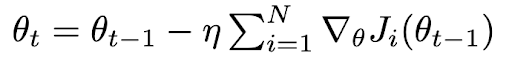

In [41]:
class SGD(Optimizer):
    def __init__(self, params, lr=1e-2):
        super().__init__(params)
        self.learning_rate = lr

    def step(self):
        with torch.no_grad():
            for param in self.params:
                if param.grad is None:
                    continue
                param -= self.learning_rate * param.grad


### Nesterov accelerated gradient
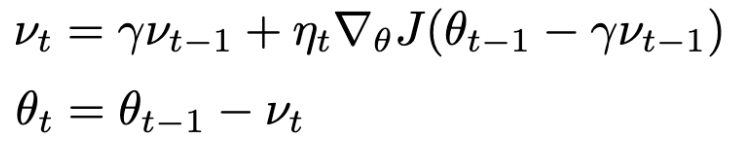

Упрощенная формула:

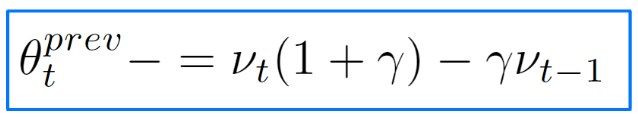

In [45]:
class NAG(Optimizer):
    def __init__(self, params, lr=1e-2, gamma=0.9):
        super().__init__(params)
        self.learning_rate = lr
        self.gamma = gamma
        self.prev_momentum = [torch.zeros(p.shape) for p in self.params]

    def get_moment(self):
        return self.prev_moment

    def step(self):
        with torch.no_grad():
            for i, param in enumerate(self.params):
                if param.grad is None:
                    continue
                prev_momentum = self.prev_momentum[i]
                self.prev_momentum[i] = self.gamma * (prev_momentum) + self.learning_rate * param.grad
                param -= (self.gamma + 1) * self.prev_momentum[i] - self.gamma * prev_momentum



### Momentum SGD

# $v_{t} = \beta \cdot v_{t-1} + \alpha \cdot \nabla \omega_{t}$

# $\omega_{t+1} = \omega_{t} - v_{t}$

In [49]:
class Momentum(Optimizer):
    def __init__(self, params, lr = 1e-2, beta = 0.9):
        super().__init__(params)
        self.learning_rate = lr
        self.beta = beta
        self.prev_momentum = [torch.zeros(p.shape) for p in self.params]

    def step(self):
        with torch.no_grad():
            for i, param in enumerate(self.params):
                if param.grad is None:
                    continue
                prev_momentum = self.prev_momentum[i]
                self.prev_momentum[i] = self.beta * prev_momentum + self.learning_rate * param.grad
                param -= self.prev_momentum[i]
        

### AdaGrad
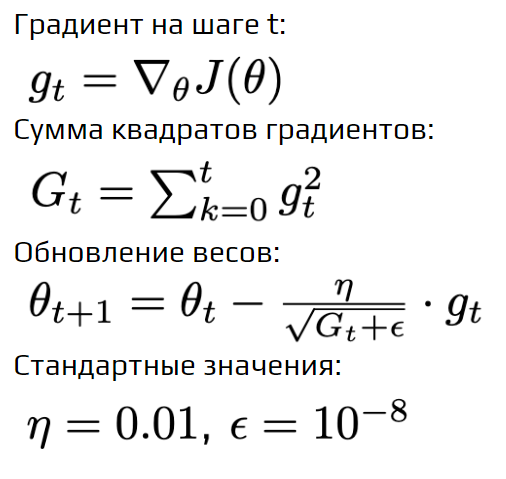

In [52]:
class AdaGrad(Optimizer):
    def __init__(self, params, epsilon=1e-8, eta=1e-2):
        super().__init__(params)
        self.epsilon = epsilon
        self.eta = eta
        self.grad_squares = [torch.zeros(p.shape) for p in self.params]

    def step(self):
        with torch.no_grad():
            for i, param in enumerate(self.params):
                if param.grad is None:
                    continue
                    
                self.grad_squares[i] += param.grad ** 2
                current_grad = param.grad
                param -= self.eta * current_grad / torch.sqrt(self.grad_squares[i] + self.epsilon)



### Adadelta



## $G_{t} = \gamma G_{t-1} + (1 - \gamma) g^2_{t}$
## $\Delta \theta = - \frac{RMS[\Delta \theta]_{t-1}}{RMS[g]_{t}} g_{t} = - \frac{\sqrt{E[\Delta \theta^{2}]_t + \varepsilon}}{\sqrt{E[g^{2}]_t + \varepsilon}}$
## $\theta_{t+1} = \theta_{t} + \Delta \theta$

## $\Delta \theta_{t} = \gamma \Delta \theta_{t-1} + (1 - \gamma) \Delta \theta^{2}$




In [55]:
class Adadelta(Optimizer):
    def __init__(self, params, epsilon=1e-6, gamma=0.9):
        super().__init__(params)
        self.epsilon = epsilon
        self.gamma = gamma
        self.grad_squares = [torch.zeros_like(p) for p in self.params]  
        self.delta = [torch.zeros_like(p) for p in self.params]  

    def step(self):
        with torch.no_grad():
            for i, param in enumerate(self.params):
                if param.grad is None:
                    continue

                self.grad_squares[i] = self.gamma * self.grad_squares[i] + (1 - self.gamma) * torch.square(param.grad)
                update = (torch.sqrt(self.delta[i] + self.epsilon) / torch.sqrt(self.grad_squares[i] + self.epsilon)) * param.grad
                param -= update
                self.delta[i] = self.gamma * self.delta[i] + (1 - self.gamma) * torch.square(update)



### RMSProp

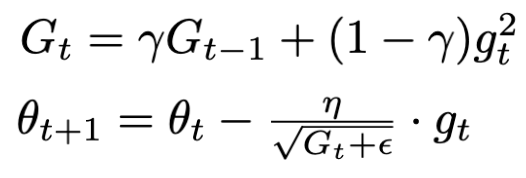

In [58]:
class RMSProp(Optimizer):
    def __init__(self, params, epsilon=1e-8, eta=1e-2, gamma=0.9):
        super().__init__(params)
        self.epsilon = epsilon
        self.eta = eta
        self.gamma = gamma
        self.smoothed_squared_gradients = [torch.zeros(p.shape) for p in self.params]

    def step(self):
        with torch.no_grad():
            for i, param in enumerate(self.params):
                if param.grad is None:
                    continue
                self.smoothed_squared_gradients[i] = self.gamma * self.smoothed_squared_gradients[i] + (1 - self.gamma) * (param.grad**2)
                param -= (self.eta *param.grad) / torch.sqrt(self.smoothed_squared_gradients[i] + self.epsilon)

### Adaptive Moment Estimation (Adam)

## 
$$ 
\begin{cases}
m_{t} = \beta_{1} m_{t-1} + (1 - \beta_{1}) g_{t} \\
\nu_{t} = \beta_{2} \nu_{t-1} + (1 - \beta_{2}) g^2_{t}
\end{cases} 
$$




$$\theta_{t+1} = \theta_{t} - \frac{\eta}{\sqrt{\hat{\nu_{t}}} + \varepsilon} \hat{m_{t}}$$

$$
\begin{cases}
\hat{m_{t}} = \frac{m_{t}}{1 - \beta^{t}_{1}} \\
\hat{\nu_{t}} = \frac{\nu_{t}}{1 - \beta^{t}_{2}}
\end{cases}
$$

In [62]:
class Adam(Optimizer):
    def __init__(self, params, lr = 1e-1, beta1 = 0.9, beta2 = 0.99, epsilon = 1e-6):
        
        super().__init__(params)
        self.learning_rate = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.momentum = [torch.zeros_like(p) for p in self.params]
        self.decay = [torch.zeros_like(p) for p in self.params]
        self.iteration = 0

    def step(self):
        with torch.no_grad():
            time = 0
            for i, param in enumerate(self.params):
                if param.grad is None:
                    continue

                self.iteration += 1
                
                momentum_prev = self.momentum[i]
                decay_prev = self.decay[i]
                
                self.momentum[i] = self.beta1 * momentum_prev + (1 - self.beta1) * param.grad
                self.decay[i] = self.beta2 * decay_prev + (1 - self.beta2) * torch.square(param.grad)

                momentum_shifted = self.momentum[i] / (1 - self.beta1**self.iteration)
                decay_shifted = self.decay[i] / (1 - self.beta2 ** self.iteration)

                # print(self.iteration)

                param -= (self.learning_rate * momentum_shifted) / (torch.sqrt(decay_shifted) + self.epsilon)
                
                

In [64]:
from functools import partial

points, losses = optimize_function(partial(loss_animator.loss_func, loss=mse), SGD, {}, start_point=[-4, -4], num_iter=100)

In [70]:
compare_optimizers(
    loss_animator,
    mse,
    [
        ['SGD', SGD, {'lr': 1e-1}],
        # ['NAG', NAG, {'lr': 1e-1}],
        ['Momentum', Momentum, {'lr': 1e-1}],
        # ['AdaGrad', AdaGrad, {'eta' : 1}],
        # ['RMSProp', RMSProp, {'eta' : 1}],
        # ['Adadelta', Adadelta, {'epsilon': 1e-1}],
        # ['Adam', Adam, {'epsilon': 1e-1, 'lr':0.5}]
    ],
    start_point=[-4, -4],
    num_iter=100
)

В качестве домашней работы (Сделано) вам необходимо будет реализовать и сравнить методы:
<b>Momentum, AdaDelta, Adam</b>.

Также вам будет предложено сравнить реализованные методы при обучении полносвязной и сверточной нейронных сетей на датасете MNIST.

